In [1]:
import os, sys, copy
import cv2
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm, notebook

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Resizing, Rescaling, Input, \
                                    MaxPooling2D, Flatten

from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/CS336

/content/drive/.shortcut-targets-by-id/1VMuLtRk8LvNQQnrce8CjNS_QHm9N8Iaa/CS336


In [4]:
DATAPATH = "/content/drive/MyDrive/CS336"

# File indexing

## Create file indexing

In [ ]:
# data_df = pd.DataFrame(columns=['index', 'path'])

In [ ]:
# i = 0
# for file in sorted(os.listdir(f"/content/drive/MyDrive/CS336/dataset")):
#     data_df.loc[i] = [i, f"/content/drive/MyDrive/CS336/dataset/{file}"]
#     i += 1

In [ ]:
# data_df

,index,path
0,0,/content/drive/MyDrive/CS336/dataset/all_souls...
1,1,/content/drive/MyDrive/CS336/dataset/all_souls...
2,2,/content/drive/MyDrive/CS336/dataset/all_souls...
3,3,/content/drive/MyDrive/CS336/dataset/all_souls...
4,4,/content/drive/MyDrive/CS336/dataset/all_souls...
...,...,...
5058,5058,/content/drive/MyDrive/CS336/dataset/worcester...
5059,5059,/content/drive/MyDrive/CS336/dataset/worcester...
5060,5060,/content/drive/MyDrive/CS336/dataset/worcester...
5061,5061,/content/drive/MyDrive/CS336/dataset/worcester...


## Load index

In [5]:
data_df = pd.read_csv("./index.csv", index_col=0)
data_df.head()

,index,path
0,0,/content/drive/MyDrive/CS336/dataset/all_souls...
1,1,/content/drive/MyDrive/CS336/dataset/all_souls...
2,2,/content/drive/MyDrive/CS336/dataset/all_souls...
3,3,/content/drive/MyDrive/CS336/dataset/all_souls...
4,4,/content/drive/MyDrive/CS336/dataset/all_souls...


# Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
input_shape = (224, 224, 3)

In [8]:
base_model = ResNet101(include_top=False, weights='imagenet', input_shape=input_shape)
model = Sequential([
                # input_layers,
                base_model,
                MaxPooling2D(strides=(7, 7)),
                Flatten()
])

# model.build((None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 2048)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 42,658,176
Trainable params: 42,552,832
Non-trainable params: 105,344
_________________________________________________________________


## Save feature vectors

In [ ]:
# features = []

In [ ]:
# for i in notebook.tqdm_notebook(range(len(data_df))):
#     img = cv2.imread(data_df.iloc[i][1])
#     img = cv2.resize(img, input_shape[: 2])
#     img = tf.expand_dims(tf.convert_to_tensor(img), axis=0)
#     feature = model.predict(img, batch_size=None).squeeze()
#     features.append(feature)

  0%|          | 0/5063 [00:00<?, ?it/s]

In [ ]:
# with open("./feature_vectors/ResNet101_mac_features.npy", 'wb') as f:
#     np.save(f, features)

# Load features

In [9]:
with open('./feature_vectors/ResNet101_mac_features.npy', 'rb') as f:
    features = np.load(f)

In [10]:
features.shape

(5063, 2048)

# Essential functions

In [11]:
def Sort_Tuple(tup): 
    tup.sort(key = lambda x: x[1]) 
    return tup 

In [12]:
def compute_ap(rel, ranked_list):
    ap = 0.0
    precision = 1.0
    intersect_size = 0
    precision_list = []
    j = 0
    for i in range(len(ranked_list)):
        if ranked_list[i] in rel:
            intersect_size += 1
            precision = intersect_size / (j + 1.0)
            precision_list.append(precision)
        j += 1
    ap = np.array(precision_list).mean()
    return ap

In [13]:
def predict(IMGPATH, kmeans, features):
  query_img = cv2.imread(IMGPATH)
  query_img = cv2.resize(query_img, input_shape[: 2])
  query_img = tf.expand_dims(tf.convert_to_tensor(query_img), axis=0)

  query_features = model.predict(query_img, batch_size=None)

  label_query = kmeans.predict(query_features.astype(np.float32))

  rank_list_features = []
  rank_list_index = []

  for index,label in enumerate(kmeans.labels_,0):
      if label == label_query:
          rank_list_features.append(features[index])
          rank_list_index.append(index)

  sim = []

  for v in zip(rank_list_features, rank_list_index):
      cos_sim = np.dot(query_features, v[0]) / (np.linalg.norm(query_features) * np.linalg.norm(v[0]))
      sim.append((cos_sim,v[1])) 

  relevant_ans = Sort_Tuple(sim)

  return relevant_ans

In [14]:
def plot_result(IMGPATH, kmeans, features):
  relevant_ans = predict(IMGPATH, kmeans, features)
  for ans in relevant_ans[:len(relevant_ans) // 2]:
      img = cv2.imread(f"{data_df.iloc[ans[1]][1]}")
      plt.figure(figsize=(8, 8))
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.show()

In [15]:
def compute_mAP(DATAPATH, kmeans, features):
  ap =[] 
  for q in sorted(os.listdir(f"{DATAPATH}/query")): 
    IMGPATH = f"/content/drive/MyDrive/CS336/query/{q}"
    relevant_ans = predict(IMGPATH, kmeans, features)
    ranked_list = []
    for ans in relevant_ans:
      ranked_list.append(f"{data_df.iloc[ans[1]][1]}".split('/')[-1].split('.')[0])

    gt = []
    grd = f"{q[: q.rindex('_')]}.txt"
    with open(f'/content/drive/MyDrive/CS336/gt/{grd}') as gt_f:
        gt = [line.strip() for line in gt_f.readlines()]

    q_ap = compute_ap(gt, ranked_list)
    ap.append(q_ap)
  return np.array(ap).mean()

In [16]:
list_mAP = []
for i in notebook.tqdm_notebook(range(50,550, 50)):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(features)
  list_mAP.append(compute_mAP(DATAPATH, kmeans, features))

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
np.around(np.array(list_mAP), decimals=3)

array([0.123, 0.154, 0.199, 0.191, 0.196, 0.223, 0.218, 0.25 , 0.26 ,
       0.258])

[]

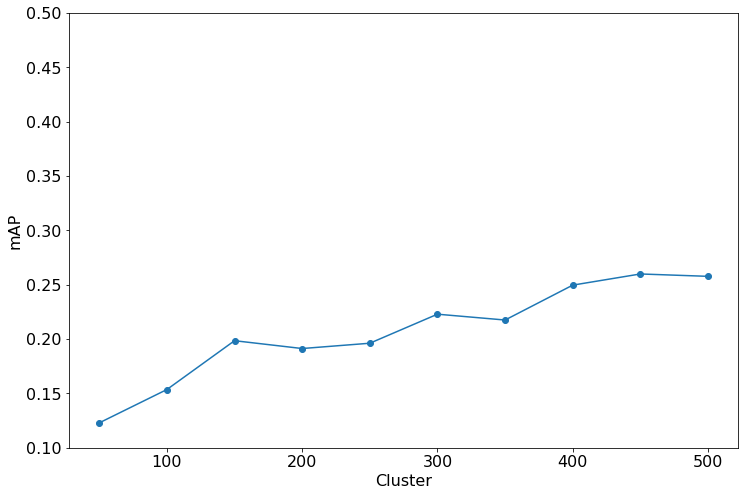

In [20]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(range(50,550,50), list_mAP, marker='o')
plt.ylim([0.10, 0.5])
plt.xlabel('Cluster')
plt.ylabel('mAP')
plt.plot()

In [ ]:
plot_result("/content/drive/MyDrive/CS336/query/all_souls_1_query.jpg", kmeans)